In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

# Supervised learning: GMMs for classification

Let us think about the generative model we used in the last notebook. For each class we implemented the following procedure
$$
\left\{
\begin{align}
{\vec m}_k &\sim \mathcal{N} (0, I_2), &\quad& k = 1, \dots, K \\
j_i &\sim \operatorname{Uniform} ([K]), &\quad& i = 1, \dots, N \\
{\vec x}_i &\sim \mathcal{N} ({\vec m}_{j_i}, \sigma^2 I_2), &\quad& i = 1, \dots, N
\end{align}
\right.
$$
Assuming the centroids are known, the likelihood for this model can be written as
$$
P({\vec x}_i | \{ {\vec m}_k \}, {\vec x} \in C_\ell) = \frac{1}{K} \sum_{k = 1}^K \mathcal{N} ({\vec x}_i ; {\vec m_k}, \sigma^2 I_2)
$$

Using Bayes theorem, we can see that the probability of $\vec x_i$ belonging to class $C_\ell$ is just $P({\vec x} \in C_\ell | {\vec x}_i, \{{\vec m}_k\})) \propto P({\vec x}_i | \{ \vec{m}_k \}, {\vec x} \in C_\ell) \, P_0 ({\vec x} \in C_\ell)$. If moreover we assume a uniform prior, determining whether a given sample belongs to class 0 or 1 is just a matter of computing the two likelihoods and seeing which one is larger.

Let us do that and compare to the k-NN estimator we studied earlier. First we generate samples as before.

In [2]:
# Samples 10 centroids for each class from two different bivariate Normal distributions
centroids_per_class = 10

class0_centroids = [1, 0] + np.random.randn(centroids_per_class, 2)
class1_centroids = [0, 1] + np.random.randn(centroids_per_class, 2)

# Given the centroids, sample data
samples_per_class = 100

class0_labels = np.random.randint(10, size = samples_per_class)
class0_samples = class0_centroids[class0_labels, :] + np.sqrt(1. / 5) * np.random.randn(samples_per_class, 2)

class1_labels = np.random.randint(10, size = samples_per_class)
class1_samples = class1_centroids[class1_labels, :] + np.sqrt(1. / 5) * np.random.randn(samples_per_class, 2)

# Put data together
X = np.vstack((class0_samples, class1_samples))
y = np.hstack((np.zeros(samples_per_class), np.ones(samples_per_class)))

Then we train our k-NN classifier. Now that we know about scikit-learn we can to that very easily :-)

In [3]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV

# Set up the grid search
parameters = [{'n_neighbors': np.arange(1, 20)}]
clf = GridSearchCV(neighbors.KNeighborsClassifier(n_neighbors = 1), parameters)
clf.fit(X, y)

# Print results
print(clf.best_params_)
print("training error = %g" % np.mean(y != clf.predict(X)))

{'n_neighbors': 5}
training error = 0.085


Again, we can also generate a test set and compute the test error.

In [4]:
# Centroids are already given; just sample the data
testsamples_per_class = 10000

class0_testlabels = np.random.randint(10, size = testsamples_per_class)
class0_testsamples = class0_centroids[class0_testlabels, :] + np.sqrt(1. / 5) * np.random.randn(testsamples_per_class, 2)

class1_testlabels = np.random.randint(10, size = testsamples_per_class)
class1_testsamples = class1_centroids[class1_testlabels, :] + np.sqrt(1. / 5) * np.random.randn(testsamples_per_class, 2)

# Put things together
X_test = np.vstack((class0_testsamples, class1_testsamples))
y_test = np.hstack((np.zeros(testsamples_per_class), np.ones(testsamples_per_class)))

# Print test error
print("test error = %g" % np.mean(y_test != clf.predict(X_test)))

test error = 0.1384


What about our Bayes-optimal classifier? Let us implement a function to compute the posterior.

In [8]:
def compute_posterior(x, centroids, var):
    return np.sum(np.exp(-.5 * np.sum((x - centroids) ** 2, 1) / var) / np.sqrt(2 * np.pi * var))

def bayes(X, m0, m1, var):
    estimate = np.zeros(len(X))
    for i in range(len(X)):
        estimate[i] = int(compute_posterior(X[i, :], m1, var) > compute_posterior(X[i, :], m0, var))
    return estimate

y_hat = bayes(X_test, class0_centroids, class1_centroids, 1./5)
print("error on test set: %g" % np.mean(y_test != y_hat))

error on test set: 0.12635


In [ ]:
# Uncomment the following line to get the solution
#%load gmm1.py

We actually got very close with the $k$-NN estimate, while not using any information at all from the model! The Bayes-optimal classifier gives us the smallest possible error, *given that* the generative model is known. Of course, that is most often not the case when one is working with real data.

Finally let's plot the posterior for each class to see how it looks like.

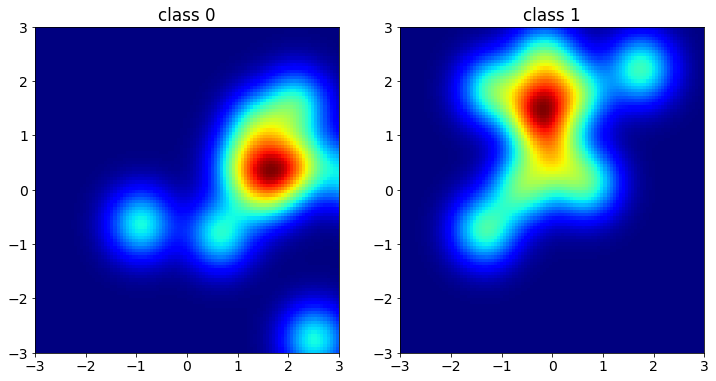

In [7]:
# Generate grid
xx, yy = np.meshgrid(np.linspace(-3, 3, 101), np.linspace(-3, 3, 101))
xs = np.c_[xx.ravel(), yy.ravel()]

# Compute posterior at each point of the grid using list comprehensions
ys0 = np.array([compute_posterior(x, class0_centroids, 1./5) for x in xs])
ys1 = np.array([compute_posterior(x, class1_centroids, 1./5) for x in xs])

# Do plot
fig, axs = plt.subplots(1, 2, figsize = (12, 6))
axs[0].pcolormesh(xx, yy, ys0.reshape((101, 101)), cmap = "jet")
axs[0].set_title("class 0")
axs[1].pcolormesh(xx, yy, ys1.reshape((101, 101)), cmap = "jet")
axs[1].set_title("class 1")

**Side exercise**: implement the Bayes classifier for the case where the centroids are not known (you will need the EM algorithm introduced by Florent yesterday). If you don't want to code everything by hand, take a look at what's available on scikit-learn.
Were you able to recover the centroids accurately?

# Unsupervised learning: GMMs for clustering

As discussed in Florent's lecture yesterday, GMMs are also very useful in the case where the labels are not known and we want to cluster the samples into different groups. Let us try to cluster the digits on MNIST to see if we are able to get a good performance.

In [10]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original', data_home = ".")

X = mnist.data
y = mnist.target

# Let's work only with 0's, 1's and 2's
mask = np.logical_or(y == 0, np.logical_or(y == 1, y == 2))
X = X[mask, :]
y = y[mask]

n_samples, n_features = np.shape(X)
print(n_samples)

21770


That's still a lot of samples, so let us reduce the size of our training set.

In [16]:
n_train_samples = 1000
train_samples = np.random.randint(n_samples, size = n_train_samples)
X_train, y_train = X[train_samples, :], y[train_samples]

Now next is quite simple to run scikit-learn's implementation of GMMs.

In [17]:
from sklearn.mixture import GaussianMixture
estimator = GaussianMixture(n_components = 3)
estimator.fit(X_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [18]:
y_hat0 = estimator.predict(X_train)

print(y_train)
print(y_hat0)

[ 0.  1.  0.  2.  2.  0.  0.  2.  1.  0.  0.  2.  1.  0.  0.  2.  2.  0.
  2.  2.  1.  1.  2.  0.  0.  0.  1.  0.  2.  2.  2.  0.  1.  0.  2.  2.
  1.  0.  0.  2.  1.  1.  0.  0.  0.  1.  1.  2.  0.  1.  1.  1.  1.  1.
  0.  0.  0.  0.  1.  2.  2.  0.  1.  0.  2.  0.  1.  2.  0.  1.  2.  0.
  0.  2.  2.  0.  0.  0.  1.  1.  1.  2.  1.  1.  2.  2.  1.  1.  2.  1.
  1.  2.  2.  1.  1.  2.  2.  0.  2.  1.  1.  2.  1.  2.  0.  1.  2.  1.
  0.  0.  1.  0.  2.  0.  2.  0.  0.  0.  0.  2.  0.  2.  1.  2.  2.  1.
  1.  1.  1.  2.  0.  0.  1.  1.  1.  1.  0.  2.  2.  0.  1.  0.  1.  2.
  1.  1.  2.  0.  2.  2.  0.  1.  1.  2.  2.  0.  0.  1.  0.  2.  1.  0.
  0.  1.  0.  0.  2.  1.  2.  0.  0.  0.  2.  1.  0.  0.  1.  2.  0.  1.
  1.  0.  2.  1.  2.  1.  0.  0.  0.  2.  0.  0.  2.  1.  2.  0.  0.  1.
  0.  0.  2.  0.  1.  1.  1.  2.  2.  0.  1.  1.  1.  0.  0.  2.  1.  0.
  2.  2.  0.  0.  2.  2.  0.  2.  1.  0.  2.  1.  0.  1.  2.  2.  2.  1.
  1.  2.  1.  2.  2.  0.  2.  2.  1.  2.  1.  1.  1

Oh-oh, these look like, completely different. What's going on? Well, of course, our model does not know the correct labels, so it cannot predict them accordingly! We need to look for permutations!

In [19]:
from itertools import permutations
for p in permutations(range(3)):
    print(p)

(0, 1, 2)
(0, 2, 1)
(1, 0, 2)
(1, 2, 0)
(2, 0, 1)
(2, 1, 0)


**Exercise**: compute error for each of the label permutations, and determine the correct one.

In [20]:
error_min = 1.0
for p in permutations(range(3)):
    # Permute labels following permutation p
    y_new = [p[yy] for yy in y_hat0]
    
    # Compute error; if smaller than min. so far, store permutation
    error = np.mean(y_new != y_train)
    if error < error_min:
        p_good = p
        error_min = error
    
    print("permutation: %s, error: %g" % (p, error))
    
# Permute labels following permutation that gives minimum error
y_hat = [p_good[yy] for yy in y_hat0]

permutation: (0, 1, 2), error: 0.988
permutation: (0, 2, 1), error: 0.731
permutation: (1, 0, 2), error: 0.609
permutation: (1, 2, 0), error: 0.069
permutation: (2, 0, 1), error: 0.943
permutation: (2, 1, 0), error: 0.66


In [ ]:
# Uncomment the following line to get the solution to the exercise
#%load gmm2.py

Finally, we can play a bit with the actual and the estimated number of classes.